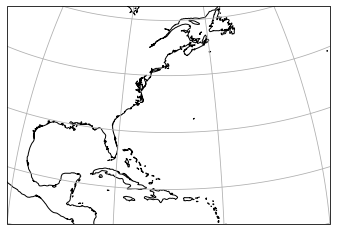

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import csv
from sklearn.preprocessing import StandardScaler

import datetime
import cartopy.crs as ccrs
import cftime

import utils

In [2]:
# Takes in a file of data and searches for row headers (i.e. the rows that correspond to a unique hurricane).
# Returns the data as a dataframe, with the row header ID as the first column.
def clean_file(filename):
    
    f = open(filename, mode='r')
    reader = csv.reader(f)
    header = []
    data = [] # 2d list to hold all the data
    for row in reader:
        if row[0].startswith("AL"): # Header row
            header = row[0]
        else:
            row.insert(0, header)# append ID to row
            data.append(row[:-1]) # don't know why theres an extra empty column
    f.close()
    df = pd.DataFrame(data, columns=['ID','Date', 'Time', 'Record', 'Status', 'Latitude', 'Longitude',
                               'Wind speed','Pressure','34NE','34SE','34SW','34NW',
                               '50NE','50SE','50SW','50NW','64NE','64SE','64SW','64NW'])
    df['Date'] = df['Date'].apply(utils.convert_time)
    
    df['Latitude'] = df['Latitude'].apply(utils.convert_coords)
    df['Longitude'] = df['Longitude'].apply(utils.convert_coords)
    return df

In [3]:
'''
Takes in a pandas dataframe of hurricane data and:
(1) Change the record identifier column into 1 if hurricane made Landfall (L), else 0
(2) adjust the date column into 3 separate columns - month, day, year. Drops date column.
(3) Imputes missing values with the mean of the column of the truncated data
(4) Standardize data for columns of continuous variables
'''

def prep_hurricane_data(df):
    
    # change record identifier (1)
    df['Record'] = pd.Series(df['Record'] == ' L', dtype=int)
    #df['Status'] = df['Status'].map({' TD':0,' TS':1,' HU':2,' EX':3,' SD':4,' SS':5,' LO':6,' WV':7,' DB':8})
    df.drop('ID', axis = 1, inplace = True)
    df.drop('Status', axis = 1, inplace = True) # this column doesn't have much useful info for our goals, its just used to categorize hurricane type
    
    
    
    # create new columns identify by the date (2)
    df['Year'] = df['Date'].apply(lambda x: x[0:4]).astype(int)
    df['Month'] = df['Date'].apply(lambda x: x[4:6]).astype(int)
    df['Day'] = df['Date'].apply(lambda x: x[6:8]).astype(int)
    df.drop('Date', axis = 1, inplace = True)

    
    # imputes missing values with mean of column of truncated data (3)
    for column in df:
        if column not in ['Latitude', 'Longitude']:
            df[column] = pd.to_numeric(df[column]) # turn every column (except lat/long) into numeric data type
        df[column].replace(-999, np.nan, inplace=True)
        if df[column].isnull().values.any():  # check for columns with nan values
            df[column].fillna(df[column].mean(skipna=True), inplace=True)  # replace all NaNs with mean of column

    return df

In [4]:
df = clean_file('hurdat2.txt')
# df = prep_hurricane_data(df)
df

,ID,Date,Time,Record,Status,Latitude,Longitude,Wind speed,Pressure,34NE,...,34SW,34NW,50NE,50SE,50SW,50NW,64NE,64SE,64SW,64NW
0,AL011851,1851-06-25 00:00:00,0000,,HU,28.0,-94.8,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,1851-06-25 00:00:00,0600,,HU,28.0,-95.4,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,1851-06-25 00:00:00,1200,,HU,28.0,-96.0,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,1851-06-25 00:00:00,1800,,HU,28.1,-96.5,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,1851-06-25 00:00:00,2100,L,HU,28.2,-96.8,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51835,AL202019,2019-11-26 00:00:00,1200,,EX,52.2,-9.3,45,970,90,...,120,90,0,0,0,0,0,0,0,0
51836,AL202019,2019-11-26 00:00:00,1800,,EX,52.2,-8.9,40,972,90,...,90,90,0,0,0,0,0,0,0,0
51837,AL202019,2019-11-27 00:00:00,0000,,EX,51.8,-8.2,40,974,0,...,90,0,0,0,0,0,0,0,0,0
51838,AL202019,2019-11-27 00:00:00,0600,,EX,51.4,-6.0,40,976,0,...,90,0,0,0,0,0,0,0,0,0


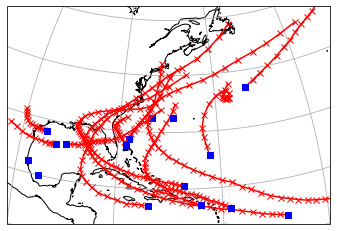

In [5]:
hurricane_IDs = df['ID'].unique()
ax = utils.create_geoaxes()

for ID in hurricane_IDs[0:20]:
    utils.plot_hurricane_trajectory(df, ID, ax=ax)

## Part 1: Predicting whether or not a hurricane will make landfall

Since the records in our hurricane dataset contain *timestamps* of specific hurricanes, it will be more useful to create a dataframe which contains key features of each individual hurricane's track. However, 

In [6]:
# Create dataframe of each individual hurricane
hurricane_IDs = df['ID'].unique()
hurricane_df = pd.DataFrame.from_dict({'ID':hurricane_IDs})
columns = ['Duration', 'Initial latitude', 'Initial longitude',
           'Makes landfall', 'Landfall latitude', 'Landfall longitude']
hurricane_df = hurricane_df.set_index(['ID'])

# Set hurricane data columns
for col in columns:
    hurricane_df[col] = None

for ID in hurricane_IDs:
    attrs = utils.get_hurricane_attributes(df, ID)
    for col in attrs:
        hurricane_df.at[ID, col] = attrs[col]
hurricane_df

,Duration,Initial latitude,Initial longitude,Makes landfall,Landfall latitude,Landfall longitude
ID,,,,,,
AL011851,14,28,-94.8,1,28.2,-96.8
AL021851,1,22.2,-97.6,0,NaN,NaN
AL031851,1,12,-60,0,NaN,NaN
AL041851,49,13.4,-48,1,30.1,-85.7
AL051851,16,32.5,-73.5,0,NaN,NaN
...,...,...,...,...,...,...
AL162019,15,22.2,-95.7,0,NaN,NaN
AL172019,10,24.7,-94.8,0,NaN,NaN
AL182019,22,40,-38.3,0,NaN,NaN


What percent of hurricanes actually make landfall?

In [7]:
sum(hurricane_df['Makes landfall'])/len(hurricane_df)

0.34231378763866877

So, we see that roughly a third of all atlantic tropical cyclones make landfall. But the code below shows that the probability of landfall strongly depends on the genesis coordinate of the cyclone. This is because, not only are more westerly coordinates simply closer to land and thus likelier to be hit, but also due to the different dynamical regimes that partition the Atlantic ocean.

In [9]:
lons = np.arange(-90, -10, 10)
for i in range(len(lons) - 1):
    lonW = lons[i]
    lonE = lons[i+1]
    subset = hurricane_df[(hurricane_df['Initial longitude'] >= lonW) & (hurricane_df['Initial longitude'] < lonE)]
    pct_landfalling = sum(subset['Makes landfall'])/len(subset)
    print('Percent of cyclones starting between longitudes', lonW, 'and', lonE, 'making landfall:',
          '{:.3}'.format(pct_landfalling))

Percent of cyclones starting between longitudes -90 and -80 making landfall: 0.564
Percent of cyclones starting between longitudes -80 and -70 making landfall: 0.374
Percent of cyclones starting between longitudes -70 and -60 making landfall: 0.242
Percent of cyclones starting between longitudes -60 and -50 making landfall: 0.266
Percent of cyclones starting between longitudes -50 and -40 making landfall: 0.158
Percent of cyclones starting between longitudes -40 and -30 making landfall: 0.138
Percent of cyclones starting between longitudes -30 and -20 making landfall: 0.148


In [52]:
lats = np.arange(0, 50, 10)
for i in range(len(lats) - 1):
    latS = lats[i]
    latN = lats[i+1]
    subset = hurricane_df[(hurricane_df['Initial latitude'] >= latS) & (hurricane_df['Initial latitude'] < latN)]
    pct_landfalling = sum(subset['Makes landfall'])/len(subset)
    print('Percent of cyclones starting between longitudes', latS, 'and', latN, 'making landfall:',
          '{:.3}'.format(pct_landfalling))

Percent of cyclones starting between longitudes 0 and 10 making landfall: 0.312
Percent of cyclones starting between longitudes 10 and 20 making landfall: 0.346
Percent of cyclones starting between longitudes 20 and 30 making landfall: 0.405
Percent of cyclones starting between longitudes 30 and 40 making landfall: 0.131


To better categorize the dynamical regimes where the cyclones start, we use k-means clustering on the initial coordinates.

In [45]:
k = 3
p = 2

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=k, p=p)
neigh.fit(hurricane_df[['Initial latitude', 'Initial longitude']])

neigh

NearestNeighbors(n_neighbors=3)

In [47]:
neigh.kneighbors(hurricane_df[['Initial latitude', 'Initial longitude']].iloc[0:10])

(array([[0.        , 0.53851648, 0.72801099],
        [0.        , 0.28284271, 0.4       ],
        [0.        , 0.        , 0.31622777],
        [0.        , 0.3       , 0.4472136 ],
        [0.        , 0.        , 0.28284271],
        [0.        , 0.1       , 0.53851648],
        [0.        , 0.53851648, 0.70710678],
        [0.        , 0.92195445, 1.39283883],
        [0.        , 0.41231056, 0.5       ],
        [0.        , 0.2236068 , 0.36055513]]),
 array([[   0, 1573, 1690],
        [   1, 1794, 1850],
        [  12,    2,  278],
        [   3,  545, 1414],
        [   4,   37, 1674],
        [   5, 1381,   64],
        [   6,  395,  233],
        [   7, 1577,  109],
        [   8, 1238,  141],
        [   9,  356,  759]]))

In [49]:
samples = [[0., 0., 0.], [0., .5, 0.], [1., 1., .5], [1, 1, 1], [.2, .5, .2]]
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(samples)

print(neigh.kneighbors([[1., 1., 1.]]))

(array([[0.]]), array([[3]]))
